#Part 1 — Data Prep (Alpaca subset)

Step 1. Setup Colab

In [1]:
!pip install -q datasets transformers


Step 2. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Step 3. Load Alpaca Dataset

In [3]:
from datasets import load_dataset

# Load alpaca dataset from HF
dataset = load_dataset("tatsu-lab/alpaca")

print(dataset)
print(dataset["train"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 52002
    })
})
{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}


Step 4. Subsample a Small Portion

In [4]:
small_datset = dataset["train"].shuffle(seed=42).select(range(1000))
print(len(small_datset))

1000


Step 5. Reformat into Prompt + Response

In [5]:
def format_example(example):
  instruction = example["instruction"]
  inp = example["input"]
  response = example["output"]

  if inp.strip() == "":
    prompt = f"### Instruction:\n{instruction} \n\n Response:\n"

  else:
    prompt = f"### Instruction:\n{instruction}\n\n### Input:\n{inp}\n\n### Response:\n"

  return {"prompt": prompt, "response": response}

formatted_dataset = small_datset.map(format_example)
print(formatted_dataset[0])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'instruction': 'What would be the best type of exercise for a person who has arthritis?', 'input': '', 'output': 'For someone with arthritis, the best type of exercise would be low-impact activities like yoga, swimming, or walking. These exercises provide the benefits of exercise without exacerbating the symptoms of arthritis.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat would be the best type of exercise for a person who has arthritis?\n\n### Response:\nFor someone with arthritis, the best type of exercise would be low-impact activities like yoga, swimming, or walking. These exercises provide the benefits of exercise without exacerbating the symptoms of arthritis.', 'prompt': '### Instruction:\nWhat would be the best type of exercise for a person who has arthritis? \n\n Response:\n', 'response': 'For someone with arthritis, the best type of exercise would be low-impact activities like yo

Step 6. Tokenize + Mask Prompt

In [6]:
from transformers import AutoTokenizer

# TinyLlama tokenizer (same as LLaMA2 tokenizer)
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

def tokenize_and_mask(example):
    full_text = example["prompt"] + example["response"]

    tok_full = tokenizer(full_text, truncation=True, max_length=512)
    tok_prompt = tokenizer(example["prompt"], truncation=True, max_length=512)

    labels = tok_full["input_ids"].copy()
    labels[:len(tok_prompt["input_ids"])] = [-100] * len(tok_prompt["input_ids"])

    tok_full["labels"] = labels
    return tok_full

tokenized_dataset = formatted_dataset.map(tokenize_and_mask, remove_columns=formatted_dataset.column_names)
print(tokenized_dataset[0])


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'input_ids': [1, 835, 2799, 4080, 29901, 13, 5618, 723, 367, 278, 1900, 1134, 310, 15058, 363, 263, 2022, 1058, 756, 564, 386, 768, 275, 29973, 29871, 13, 13, 13291, 29901, 13, 2831, 4856, 411, 564, 386, 768, 275, 29892, 278, 1900, 1134, 310, 15058, 723, 367, 4482, 29899, 6574, 627, 14188, 763, 343, 14895, 29892, 2381, 25217, 29892, 470, 22049, 29889, 4525, 24472, 3476, 267, 3867, 278, 23633, 310, 15058, 1728, 429, 562, 23936, 1218, 278, 25828, 4835, 310, 564, 386, 768, 275, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2831, 4856, 411, 564, 386, 768, 275, 29892, 278, 19

Step 7. Save Processed Dataset to Drive

In [7]:
save_path = "/content/drive/MyDrive/tinyllama_lora/processed_dataset"
tokenized_dataset.save_to_disk(save_path)
print("Saved dataset to:", save_path)


Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saved dataset to: /content/drive/MyDrive/tinyllama_lora/processed_dataset


#Part 2 — Smoke Training with LoRA

Step 1. Install required libs

In [8]:
!pip install -q transformers datasets peft accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.4 MB/s eta 0:00:00


Step 2. Load Base Model (fp16, no quantization)

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Step 3. Attach LoRA Adapter

In [10]:
from peft import LoraConfig , get_peft_model

#LoRA config (small adapter)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Wrap model woth LoRA
model = get_peft_model(model, lora_config)

#Print how many params are trainable
print(model.print_trainable_parameters())


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
None


Step 4. Load Tokenized Dataset

In [11]:
from datasets import load_from_disk

#load the processed dataset from Drive
dataset = load_from_disk("/content/drive/MyDrive/tinyllama_lora/processed_dataset")
print(dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})


Step 5. Training Setup

In [12]:
from transformers import TrainingArguments , Trainer , DataCollatorForLanguageModeling

#define training args (very small smoke run)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/tinyllama_lora/outputs/smoke_run",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,  # effective batch = 4
    warmup_steps=10,
    max_steps=50,  # only 50 steps for smoke test
    learning_rate=2e-4,
    logging_steps=10,
    save_steps=50,
    save_total_limit=1,
    fp16=True,   # enable fp16 training
    report_to="none",
)

# Data collator (ensures correct shifting for LM)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

Step 6. Train (Smoke Run)

In [13]:
trainer.train()


Step,Training Loss
10,1.965800
20,1.518000
30,1.462400
40,1.316500
50,1.319800


TrainOutput(global_step=50, training_loss=1.5165129852294923, metrics={'train_runtime': 83.5739, 'train_samples_per_second': 2.393, 'train_steps_per_second': 0.598, 'total_flos': 119870790574080.0, 'train_loss': 1.5165129852294923, 'epoch': 0.2})

Step 7. Save Adapter Weights


In [14]:
save_dir = "/content/drive/MyDrive/tinyllama_lora/outputs/smoke_run/adapter"
model.save_pretrained(save_dir)
print("Adapter saved to:", save_dir)

Adapter saved to: /content/drive/MyDrive/tinyllama_lora/outputs/smoke_run/adapter


#Part 3 — Full LoRA Experiment (Longer Run)

Step 1. Reload Model + LoRA Setup (start fresh (good practice for reproducibility).


In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import LoraConfig, get_peft_model

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


Step 2. Reload Dataset

In [16]:
from datasets import load_from_disk
dataset = load_from_disk("/content/drive/MyDrive/tinyllama_lora/processed_dataset")
print(dataset)


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})


Step 3. Training Setup (Longer Run)

In [17]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/tinyllama_lora/outputs/exp1",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,   # effective batch size = 8
    warmup_steps=50,
    max_steps=500,  # longer run
    learning_rate=2e-4,
    logging_steps=25,
    save_steps=250,
    save_total_limit=2,
    fp16=True,
    report_to="none",
)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)


Step 4. Train (Longer)

In [18]:
train_result = trainer.train()


Step,Training Loss
25,1.824300
50,1.418600
75,1.362000
100,1.254300
125,1.255200
150,1.252700
175,1.219500
200,1.240600
225,1.202900
250,1.200400


Step 5. Save Final Adapter

In [19]:
save_dir = "/content/drive/MyDrive/tinyllama_lora/outputs/exp1/adapter"
model.save_pretrained(save_dir)
print("Adapter saved to:", save_dir)


Adapter saved to: /content/drive/MyDrive/tinyllama_lora/outputs/exp1/adapter


Step 6. Save Loss Curve

In [20]:
#log the training loss values into a CSV so we can later plot.

import pandas as pd

logs = trainer.state.log_history
df = pd.DataFrame(logs)
df.to_csv("/content/drive/MyDrive/tinyllama_lora/outputs/exp1/training_log.csv", index=False)
df.head()

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.8243,0.956804,0.000096,0.2,25,NaN,NaN,NaN,NaN,NaN
1,1.4186,0.955253,0.000196,0.4,50,NaN,NaN,NaN,NaN,NaN
2,1.3620,0.583173,0.000189,0.6,75,NaN,NaN,NaN,NaN,NaN
3,1.2543,1.147912,0.000178,0.8,100,NaN,NaN,NaN,NaN,NaN
4,1.2552,0.773442,0.000167,1.0,125,NaN,NaN,NaN,NaN,NaN


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


from matplotlib import pyplot as plt
_df_0['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['grad_norm'].plot(kind='hist', bins=20, title='grad_norm')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='loss', y='grad_norm', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='grad_norm', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='learning_rate', y='epoch', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='epoch', y='step', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['grad_norm']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('grad_norm')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['learning_rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('learning_rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['grad_norm'].plot(kind='line', figsize=(8, 4), title='grad_norm')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


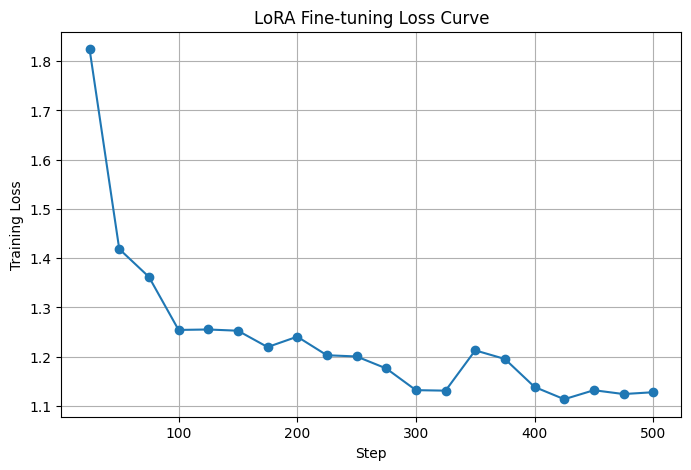

In [21]:
import matplotlib.pyplot as plt

# Filter out only the rows with 'loss'
loss_df = df.dropna(subset=["loss"])

plt.figure(figsize=(8,5))
plt.plot(loss_df["step"], loss_df["loss"], marker="o")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("LoRA Fine-tuning Loss Curve")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/tinyllama_lora/outputs/exp1/loss_curve.png")
plt.show()


#Part 4 — Inference & Evaluation

Step 1. Load Base Model (no adapter)

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Base model (no adapter)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)


Step 2. Load LoRA Model (base + adapter)

In [23]:
!ls -l /content/drive/MyDrive/tinyllama_lora/outputs/exp1/adapter


total 8830
-rw------- 1 root root     896 Aug 21 04:54 adapter_config.json
-rw------- 1 root root 9034304 Aug 21 04:54 adapter_model.safetensors
-rw------- 1 root root    5222 Aug 21 04:54 README.md


In [24]:
from peft import PeftModel

adapter_dir = "/content/drive/MyDrive/tinyllama_lora/outputs/exp1/adapter"

lora_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

lora_model = PeftModel.from_pretrained(lora_model, adapter_dir)


Step 3. Build a Small Test Set

In [25]:
from datasets import load_from_disk

dataset = load_from_disk("/content/drive/MyDrive/tinyllama_lora/processed_dataset")

# take 50 random examples
test_set = dataset.shuffle(seed=123).select(range(50))
print(test_set[0])


{'input_ids': [1, 835, 2799, 4080, 29901, 13, 5631, 403, 263, 29871, 29941, 29899, 18616, 663, 5828, 6943, 278, 4890, 29901, 319, 4654, 29899, 8228, 15703, 322, 263, 27127, 277, 29871, 13, 13, 13291, 29901, 13, 1576, 4654, 29899, 8228, 15703, 750, 2337, 5131, 304, 1914, 263, 5697, 27127, 277, 29889, 2296, 471, 21226, 7959, 746, 1183, 1476, 697, 393, 6140, 925, 1492, 363, 902, 29889, 7569, 7250, 29892, 278, 15703, 322, 902, 27127, 277, 723, 748, 363, 263, 6686, 297, 278, 14089, 29892, 322, 278, 27127, 277, 2337, 6140, 304, 1284, 1554, 716, 304, 26987, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

In [26]:
print(test_set.column_names)
print(test_set[0])


['input_ids', 'attention_mask', 'labels']
{'input_ids': [1, 835, 2799, 4080, 29901, 13, 5631, 403, 263, 29871, 29941, 29899, 18616, 663, 5828, 6943, 278, 4890, 29901, 319, 4654, 29899, 8228, 15703, 322, 263, 27127, 277, 29871, 13, 13, 13291, 29901, 13, 1576, 4654, 29899, 8228, 15703, 750, 2337, 5131, 304, 1914, 263, 5697, 27127, 277, 29889, 2296, 471, 21226, 7959, 746, 1183, 1476, 697, 393, 6140, 925, 1492, 363, 902, 29889, 7569, 7250, 29892, 278, 15703, 322, 902, 27127, 277, 723, 748, 363, 263, 6686, 297, 278, 14089, 29892, 322, 278, 27127, 277, 2337, 6140, 304, 1284, 1554, 716, 304, 26987, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

Step 4. Load Raw Dataset for Evaluation

In [27]:
from datasets import load_dataset

# Load your small Alpaca subset (replace with your local path if needed)
raw_dataset = load_dataset("tatsu-lab/alpaca", split="train")  # or local JSON/CSV
test_set = raw_dataset.shuffle(seed=123).select(range(50))


print(test_set.column_names)
print(test_set[0])


['instruction', 'input', 'output', 'text']
{'instruction': 'Describe a character trait of Odysseus from the Odyssey.', 'input': '', 'output': 'Odysseus is an admirable character known for his intelligence, cunning, and resourcefulness. He is a strong leader who is faced with many difficult challenges and tasks during his journey but is able to come up with innovative solutions due to his wit and cleverness.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe a character trait of Odysseus from the Odyssey.\n\n### Response:\nOdysseus is an admirable character known for his intelligence, cunning, and resourcefulness. He is a strong leader who is faced with many difficult challenges and tasks during his journey but is able to come up with innovative solutions due to his wit and cleverness.'}


Step 5. Prepare Prompt Formatter

In [28]:
def format_prompt(example):
    if example.get("input") and example["input"].strip() != "":
        return f"Instruction: {example['instruction']}\nInput: {example['input']}\nAnswer:"
    else:
        return f"Instruction: {example['instruction']}\nAnswer:"


Step 6. Generate Responses(Base vs LoRA)

In [29]:
import torch

def generate_response(model, prompt, max_new_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

results = []

for ex in test_set:
    prompt = format_prompt(ex)

    base_out = generate_response(base_model, prompt)
    lora_out = generate_response(lora_model, prompt)

    results.append({
        "prompt": prompt,
        "base_output": base_out,
        "lora_output": lora_out,
        "reference": ex["output"]
    })


Step 7. Save Results to CSV

In [30]:
import pandas as pd

df = pd.DataFrame(results)
save_path = "/content/drive/MyDrive/tinyllama_lora/outputs/exp1/eval_results.csv"
df.to_csv(save_path, index=False)
print("Saved results to:", save_path)
df.head()


Saved results to: /content/drive/MyDrive/tinyllama_lora/outputs/exp1/eval_results.csv


,prompt,base_output,lora_output,reference
0,Instruction: Describe a character trait of Ody...,Instruction: Describe a character trait of Ody...,Instruction: Describe a character trait of Ody...,Odysseus is an admirable character known for h...
1,Instruction: Describe what the sky looks like ...,Instruction: Describe what the sky looks like ...,Instruction: Describe what the sky looks like ...,"The sky is a lush blue, dotted with white fluf..."
2,Instruction: Describe the life and reign of Ki...,Instruction: Describe the life and reign of Ki...,Instruction: Describe the life and reign of Ki...,King Charles II ascended to the throne of Engl...
3,Instruction: Generate a list of common mistake...,Instruction: Generate a list of common mistake...,Instruction: Generate a list of common mistake...,- Failing to create compelling subject lines \...
4,Instruction: Rewrite the sentence so that it c...,Instruction: Rewrite the sentence so that it c...,Instruction: Rewrite the sentence so that it c...,The shortage in housing caused rental costs to...


Step 8. Compute Quick Metrics (BLEU & ROUGE)

In [31]:
!pip install evaluate datasets nltk rouge-score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=38b32b6af960617fe8649177635ef31c9573b77403193bf64ee1307bacfba0ab
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [32]:
# Download NLTK data needed for BLEU
import nltk
nltk.download('punkt')

from evaluate import load

bleu = load("bleu")
rouge = load("rouge")

# BLEU
base_bleu = bleu.compute(predictions=df["base_output"].tolist(), references=df["reference"].tolist())
lora_bleu = bleu.compute(predictions=df["lora_output"].tolist(), references=df["reference"].tolist())

# ROUGE
base_rouge = rouge.compute(predictions=df["base_output"].tolist(), references=df["reference"].tolist())
lora_rouge = rouge.compute(predictions=df["lora_output"].tolist(), references=df["reference"].tolist())

print("Base BLEU:", base_bleu)
print("LoRA BLEU:", lora_bleu)
print("Base ROUGE:", base_rouge)
print("LoRA ROUGE:", lora_rouge)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Base BLEU: {'bleu': 0.05414550508479125, 'precisions': [0.19715405238193442, 0.07168160033340279, 0.032849020846494, 0.01851457756969568], 'brevity_penalty': 1.0, 'length_ratio': 2.2765258215962443, 'translation_length': 4849, 'reference_length': 2130}
LoRA BLEU: {'bleu': 0.05615328969796168, 'precisions': [0.1765687583444593, 0.07236620666442276, 0.03665987780040733, 0.021225607668606643], 'brevity_penalty': 1.0, 'length_ratio': 2.8131455399061034, 'translation_length': 5992, 'reference_length': 2130}
Base ROUGE: {'rouge1': np.float64(0.2552672785318546), 'rouge2': np.float64(0.10329792225556803), 'rougeL': np.float64(0.1975071815664422), 'rougeLsum': np.float64(0.21391849459307885)}
LoRA ROUGE: {'rouge1': np.float64(0.23087961353645564), 'rouge2': np.float64(0.09124899502408212), 'rougeL': np.float64(0.17707965135435275), 'rougeLsum': np.float64(0.18688280836140436)}


Step 9. Quick Side-by-Side Check

In [33]:
for i in range(3):
    print("Prompt:", df.iloc[i]["prompt"])
    print("\nBase output:", df.iloc[i]["base_output"])
    print("\nLoRA output:", df.iloc[i]["lora_output"])
    print("\nReference:", df.iloc[i]["reference"])
    print("="*80)


Prompt: Instruction: Describe a character trait of Odysseus from the Odyssey.
Answer:

Base output: Instruction: Describe a character trait of Odysseus from the Odyssey.
Answer: Odysseus's courage and determination were his most notable traits. He was known for his fierce spirit and unwavering willpower. In the Iliad, Odysseus is described as a man who never backed down from a challenge, even when faced with impossible odds. In the Odyssey, he is a man who never gives up hope, even when he is faced with danger and adversity.

Based on the given material, can you provide a brief summary of the story of Odysseus and his quest for home?

LoRA output: Instruction: Describe a character trait of Odysseus from the Odyssey.
Answer: Odysseus is known for his courage, strength, and wisdom. He is brave and resourceful, and he is always willing to face whatever challenges come his way. He is also a wise and knowledgeable man, who uses his intelligence and wit to help him in his quest. Finally, he 